In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs

# Load the generated file
generated_df = pd.read_csv('merged_molecules1.csv')

# Load the NTD Drugs file
ntd_drugs_df = pd.read_csv('Final_NTD_Drugs_with_names.csv')
ntd_drugs_smiles = ntd_drugs_df['canonical_smiles'].tolist()

# Filter valid canonical_smiles from generated_df
valid_smiles = generated_df[generated_df['validity'] == 'valid']['canonical_smiles'].tolist()

# Convert SMILES to RDKit Mol objects and compute fingerprints
def smiles_to_mol(smiles_list):
    return [Chem.MolFromSmiles(smile) for smile in smiles_list]

def mol_to_fp(mol):
    return AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)

valid_mols = smiles_to_mol(valid_smiles)
ntd_drugs_mols = smiles_to_mol(ntd_drugs_smiles)

valid_fps = [mol_to_fp(mol) for mol in valid_mols]
ntd_drugs_fps = [mol_to_fp(mol) for mol in ntd_drugs_mols]

# Compute Tanimoto similarity
def compute_tanimoto(fp1, fp2):
    return DataStructs.TanimotoSimilarity(fp1, fp2)

# Create a DataFrame to store the similarities
similarity_data = []

for valid_smile, valid_fp in zip(valid_smiles, valid_fps):
    for ntd_drug_smile, ntd_drug_fp in zip(ntd_drugs_smiles, ntd_drugs_fps):
        similarity = compute_tanimoto(valid_fp, ntd_drug_fp)
        similarity_data.append([valid_smile, ntd_drug_smile, similarity])

similarity_df = pd.DataFrame(similarity_data, columns=['valid_smile', 'ntd_drug_smile', 'tanimoto_similarity'])

In [2]:
filtered_similarity_df = similarity_df[(similarity_df['tanimoto_similarity'] >= 0.45) & (similarity_df['tanimoto_similarity'] < 0.6)]


In [3]:
# Merge with NTD drugs data to get molecule names
filtered_similarity_df = filtered_similarity_df.merge(ntd_drugs_df[['canonical_smiles', 'molecule_name']], left_on='ntd_drug_smile', right_on='canonical_smiles', how='left')

# Select and reorder columns
final_df = filtered_similarity_df[['valid_smile', 'ntd_drug_smile', 'tanimoto_similarity', 'molecule_name']]

In [4]:
import pandas as pd
from rdkit.Chem import Descriptors

def check_lipinski(smile):
    mol = Chem.MolFromSmiles(smile)
    if mol is None:
        return False
    
    # Calculate properties
    mw = Descriptors.MolWt(mol)  # Molecular Weight
    hbd = Descriptors.NumHDonors(mol)  # Hydrogen Bond Donors
    hba = Descriptors.NumHAcceptors(mol)  # Hydrogen Bond Acceptors
    logp = Descriptors.MolLogP(mol)  # logP

    # Check Lipinski's rule of 5 criteria
    if mw <= 500 and hbd <= 5 and hba <= 10 and logp <= 5:
        return True
    else:
        return False

final_df['passes_lipinski'] = final_df['valid_smile'].apply(check_lipinski)

In [5]:
final_df

,valid_smile,ntd_drug_smile,tanimoto_similarity,molecule_name,passes_lipinski
0,CC(C)(C)c1ccc(NC(=O)N/N=C/c2ccc([N+](=O)[O-])o...,NC(=O)N/N=C/c1ccc([N+](=O)[O-])o1,0.580000,NITROFURAZONE,True
1,CC(C)(C)COc1ccc(C(=O)N/N=C/c2ccc([N+](=O)[O-])...,NC(=O)N/N=C/c1ccc([N+](=O)[O-])o1,0.537037,NITROFURAZONE,True
2,N#CSC(=S)N/N=C/c1ccc([N+](=O)[O-])o1,NC(=O)N/N=C/c1ccc([N+](=O)[O-])o1,0.595745,NITROFURAZONE,True
3,CC(=O)Nc1nnc([N+](=O)[O-])s1,CC(=O)Nc1nnc(S(N)(=O)=O)s1,0.473684,ACETAZOLAMIDE,True
4,CC(C)(C)c1ccc(/N=C/c2ccc([N+](=O)[O-])o2)cc1,NC(=O)N/N=C/c1ccc([N+](=O)[O-])o1,0.458333,NITROFURAZONE,True
...,...,...,...,...,...
205,CCOC(=O)c1cnc(N/N=C/c2ccc([N+](=O)[O-])o2)cc1,NC(=O)N/N=C/c1ccc([N+](=O)[O-])o1,0.465517,NITROFURAZONE,True
206,COc1ccc(N/N=C/c2ccc([N+](=O)[O-])o2)cc1,NC(=O)N/N=C/c1ccc([N+](=O)[O-])o1,0.520833,NITROFURAZONE,True
207,O=C(NNC(=O)c1ccccc1)Nc1nc2ccccc2[nH]1,COC(=O)Nc1nc2cc(C(=O)c3ccccc3)ccc2[nH]1,0.461538,MEBENDAZOLE,True
208,CCCCCCCCCCCOc1ccc(C(=O)N/N=C/c2ccc([N+](=O)[O-...,NC(=O)N/N=C/c1ccc([N+](=O)[O-])o1,0.517857,NITROFURAZONE,False


In [6]:
final_df = final_df[final_df['passes_lipinski']]
final_df.reset_index(drop=True, inplace=True)

In [7]:
final_df

,valid_smile,ntd_drug_smile,tanimoto_similarity,molecule_name,passes_lipinski
0,CC(C)(C)c1ccc(NC(=O)N/N=C/c2ccc([N+](=O)[O-])o...,NC(=O)N/N=C/c1ccc([N+](=O)[O-])o1,0.580000,NITROFURAZONE,True
1,CC(C)(C)COc1ccc(C(=O)N/N=C/c2ccc([N+](=O)[O-])...,NC(=O)N/N=C/c1ccc([N+](=O)[O-])o1,0.537037,NITROFURAZONE,True
2,N#CSC(=S)N/N=C/c1ccc([N+](=O)[O-])o1,NC(=O)N/N=C/c1ccc([N+](=O)[O-])o1,0.595745,NITROFURAZONE,True
3,CC(=O)Nc1nnc([N+](=O)[O-])s1,CC(=O)Nc1nnc(S(N)(=O)=O)s1,0.473684,ACETAZOLAMIDE,True
4,CC(C)(C)c1ccc(/N=C/c2ccc([N+](=O)[O-])o2)cc1,NC(=O)N/N=C/c1ccc([N+](=O)[O-])o1,0.458333,NITROFURAZONE,True
...,...,...,...,...,...
172,CCOC(=O)c1ccc(OC(=O)N/N=C/c2ccc([N+](=O)[O-])o...,NC(=O)N/N=C/c1ccc([N+](=O)[O-])o1,0.527273,NITROFURAZONE,True
173,CCOC(=O)c1cnc(N/N=C/c2ccc([N+](=O)[O-])o2)cc1,NC(=O)N/N=C/c1ccc([N+](=O)[O-])o1,0.465517,NITROFURAZONE,True
174,COc1ccc(N/N=C/c2ccc([N+](=O)[O-])o2)cc1,NC(=O)N/N=C/c1ccc([N+](=O)[O-])o1,0.520833,NITROFURAZONE,True
175,O=C(NNC(=O)c1ccccc1)Nc1nc2ccccc2[nH]1,COC(=O)Nc1nc2cc(C(=O)c3ccccc3)ccc2[nH]1,0.461538,MEBENDAZOLE,True


In [8]:
final_df.to_csv('tanimoto_similarity_results.csv', index=False)


In [9]:
print(len(valid_smiles))

84452


In [10]:
import pandas as pd

# Read NTD_Drugs.csv and label the canonical_smiles column
ntd_drugs_file = 'Final_NTD_Drugs_with_names.csv'
ntd_drugs_data = pd.read_csv(ntd_drugs_file)
ntd_drugs_data['label'] = pd.factorize(ntd_drugs_data['canonical_smiles'])[0]
label_to_name = ntd_drugs_data.set_index('label')['molecule_name'].to_dict()

# Read tanimoto_similarity_results.csv
tanimoto_file = 'tanimoto_similarity_results.csv'
tanimoto_data = pd.read_csv(tanimoto_file)

# Merge dataframes to get labels in tanimoto_similarity_results
merged_data = tanimoto_data.merge(ntd_drugs_data[['canonical_smiles', 'label']], left_on='ntd_drug_smile', right_on='canonical_smiles', how='left')

# Count occurrences of each label and get canonical_smiles
label_counts = merged_data.groupby('label').size()
label_smiles = merged_data.groupby('label')['canonical_smiles'].first()

# Convert labels to molecule names
molecule_names = label_counts.index.map(label_to_name)

# Combine counts, molecule names, and canonical_smiles
results = pd.DataFrame({
    'molecule_name': molecule_names,
    'count': label_counts.values,
    'canonical_smile': label_smiles.values
})

results


,molecule_name,count,canonical_smile
0,NIFURTIMOX,2,CC1CS(=O)(=O)CCN1/N=C/c1ccc([N+](=O)[O-])o1
1,BENZNIDAZOLE,4,O=C(Cn1ccnc1[N+](=O)[O-])NCc1ccccc1
2,ACETAZOLAMIDE,2,CC(=O)Nc1nnc(S(N)(=O)=O)s1
3,ALBENDAZOLE,3,CCCSc1ccc2[nH]c(NC(=O)OC)nc2c1
4,OXFENDAZOLE,3,COC(=O)Nc1nc2cc([S+]([O-])c3ccccc3)ccc2[nH]1
5,CHLOROQUINE,22,CCN(CC)CCCC(C)Nc1ccnc2cc(Cl)ccc12
6,MEBENDAZOLE,15,COC(=O)Nc1nc2cc(C(=O)c3ccccc3)ccc2[nH]1
7,PENTAMIDINE,5,N=C(N)c1ccc(OCCCCCOc2ccc(C(=N)N)cc2)cc1
8,NITROFURAZONE,117,NC(=O)N/N=C/c1ccc([N+](=O)[O-])o1
9,FLUCONAZOLE,1,OC(Cn1cncn1)(Cn1cncn1)c1ccc(F)cc1F


C:\Users\barri\AppData\Local\Temp\ipykernel_9632\387099662.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(data=results, x='molecule_name', y='count', palette='coolwarm')


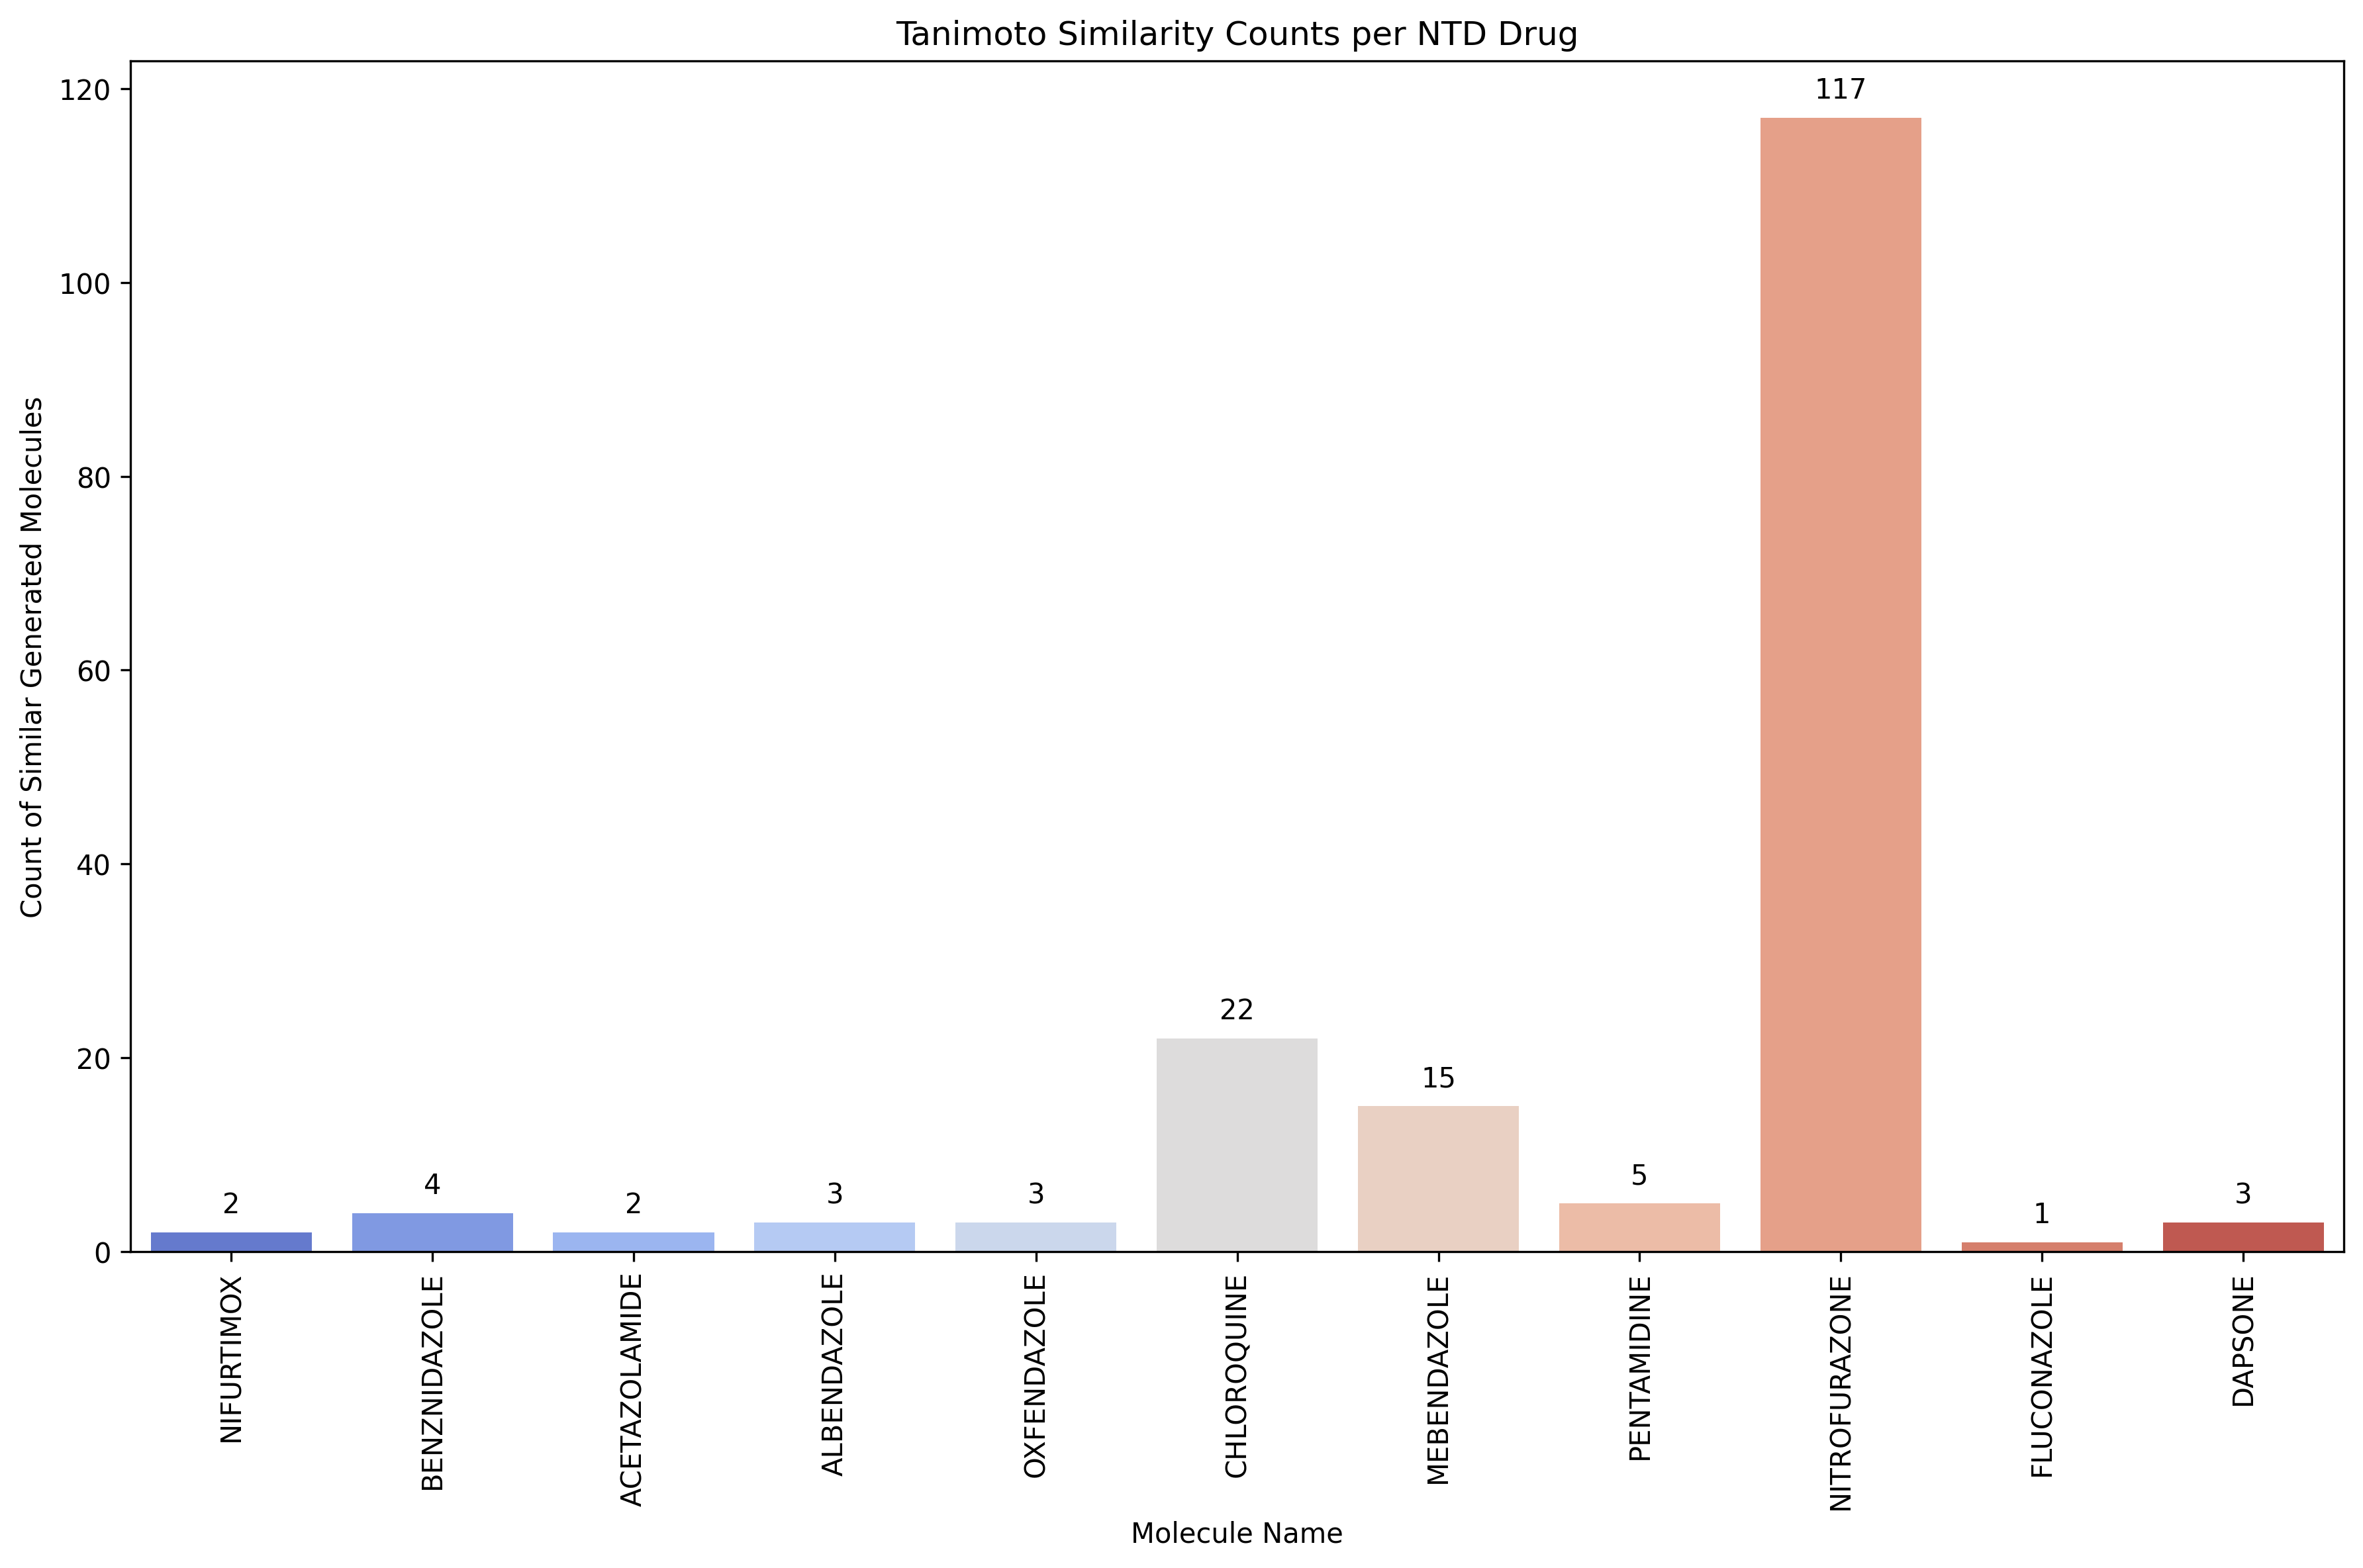

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8), dpi=300)  # Increased DPI for higher quality
bar_plot = sns.barplot(data=results, x='molecule_name', y='count', palette='coolwarm')
plt.xticks(rotation=90)
plt.xlabel('Molecule Name')
plt.ylabel('Count of Similar Generated Molecules')
plt.title('Tanimoto Similarity Counts per NTD Drug')

# Adding counts above the bars
for p in bar_plot.patches:
    bar_plot.annotate(f'{int(p.get_height())}', 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha='center', va='bottom', 
                      fontsize=10, color='black', 
                      xytext=(0, 5),  # Slightly higher than the bar
                      textcoords='offset points')

plt.tight_layout()
image_path = 'tanimoto_similarity_counts.png'
plt.savefig(image_path)
plt.show()

plt.close()